# MyMDB Analyzer
This notebook accesses the IMDb-Scraping pipeline consisting of the webscraper, the database connector and provides a GUI for the interactive visualization.

![IMDb Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/440px-IMDB_Logo_2016.svg.png)

[Wikipedia IMDb Definition](https://en.wikipedia.org/wiki/IMDb):

IMDb (an acronym for `I`nternet `M`ovie `D`ata`b`ase) is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online – including cast, production crew and personal biographies [...]

This notebook visually explores rankings of movies and actors and 

## USAGE
Step through this notebook manually so everything is executed in order

#### OVERCOMING TECHNICAL DIFFICULTIES

In [1]:
# workarround for using event_loops in notebooks (ipykernel already uses the global non-reentrant one)
import nest_asyncio
nest_asyncio.apply()

#### Imports

In [2]:
import db
import analyze
import ui

connecting to db via conn_str: DRIVER=SQL Server;SERVER=localhost;PORT=1433;DATABASE=MyMDB;UID=SA;PWD=Pr0dRdyPw!


### SCRAPING
Challenges were respecting the site's scraping rules located in robots.txt, not getting timed out even though we followed through and handling those timeouts as well as handling (rather omitting a ton of) missing/format-inhomogenous data as well as asynchronous caching in python.

In [3]:
movies = []
import_ui = ui.init_ui(movies)
import_ui

10 movies acquired

In [5]:
movies = import_ui.movies
# try:
#     movies = import_ui.movies
# except AttributeError:
#     input("press enter to continue")
#     movies = import_ui.movies

### INSERTION
This part was done purely in the SQL Server Backend, using a stored procedure for parsing the insertion data, and taking care of NaN values and the likes.

A trigger was used to recursively update the average instead of recomputation over several tables for each new insert.

In [6]:
for movie in movies:
    try:
        db.insert_movie(**movie)
    except Exception as e:
        print(f"issue at {movie}\n{e}")
"no duplicates found" if db.check_no_duplicates() else "duplicates in actors detected"

'no duplicates found'

### READING
For further analysis the movies are queried back from the db and converted to dataframes

In [7]:
df_movies = analyze.get_movie_dataframe()
df_actors = analyze.get_actors_dataframe()
df_movie_actors = analyze.get_movie_actors_dataframe()
df_actor_features = analyze.get_actor_feature_dataframe()
df_summary = (
 analyze.get_summary_dataframe()
 .sort_values(by="name")
)

display("movies", df_movies.head())
display("actors", df_actors.head())
display("movie_actors", df_movie_actors.head(5))
display("joined data", df_summary.head(10))
display(
    df_summary
    .drop(["movie_id", "actor_id"], axis=1)
    .describe()
)
display("interesting features for actor analysis", df_actor_features.head())
display(df_actor_features.describe())

'movies'

,id,title,year,genre,rating,budget,gross_income
0,253,The Dark Knight,2008,Action,9.0,185000000.0000,1006234167.0000
1,257,Schindlers Liste,1993,Biografie,8.9,22000000.0000,322161245.0000
2,259,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
3,262,Der Herr der Ringe: Die Rückkehr des Königs,2003,Action,8.9,94000000.0000,1147633833.0000
4,265,Der Herr der Ringe: Die Gefährten,2001,Action,8.8,93000000.0000,898204420.0000


'actors'

,id,name,age,avg_rating
0,1152,Cillian Murphy,47,9.0
1,1153,Ritchie Coster,56,9.0
2,1154,Morgan Freeman,86,9.0
3,1155,Michael Caine,90,9.0
4,1156,Chin Han,53,9.0


'movie_actors'

,movie_id,actor_id
0,253,1152
1,253,1153
2,253,1154
3,253,1155
4,253,1156


'joined data'

,name,age,avg_rating,movie_id,actor_id,title,year,genre,rating,budget,gross_income
18,Abe Vigoda,102,9.2,259,1203,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
8,Adi Nitzan,-1,8.9,257,1184,Schindlers Liste,1993,Biografie,8.9,22000000.0000,322161245.0000
17,Al Lettieri,95,9.2,259,1202,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
46,Al Mulock,98,8.8,266,1252,Zwei glorreiche Halunken,1966,Abenteuer,8.8,1200000.0000,25253887.0000
45,Aldo Sambrell,92,8.8,266,1251,Zwei glorreiche Halunken,1966,Abenteuer,8.8,1200000.0000,25253887.0000
31,Alistair Browning,69,8.9,262,1224,Der Herr der Ringe: Die Rückkehr des Königs,2003,Action,8.9,94000000.0000,1147633833.0000
50,Amanda Plummer,66,8.8,267,1256,Pulp Fiction,1994,Krimi,8.8,8000000.0000,213928762.0000
35,Billy Boyd,54,8.9,265,1222,Der Herr der Ringe: Die Gefährten,2001,Action,8.8,93000000.0000,898204420.0000
29,Billy Boyd,54,8.9,262,1222,Der Herr der Ringe: Die Rückkehr des Königs,2003,Action,8.9,94000000.0000,1147633833.0000
27,Billy Nelson,120,9.0,270,1278,Die zwölf Geschworenen,1957,Krimi,9.0,350000.0000,955.0000


,age,avg_rating,year
count,62.000000,62.000000,62.000000
mean,66.709677,8.961290,1987.983871
std,37.605540,0.148605,17.099029
min,-1.000000,8.800000,1957.000000
25%,53.250000,8.800000,1972.000000
50%,70.000000,8.900000,1994.000000
75%,97.750000,9.000000,2001.000000
max,126.000000,9.200000,2008.000000


'interesting features for actor analysis'

,name,age,appearances,avg_rating
0,Sterling Hayden,107,1,9.2
1,Richard Conte,113,1,9.2
2,Paul McCrane,62,1,9.2
3,John Cazale,87,1,9.2
4,Jeffrey DeMunn,76,1,9.2


,age,appearances,avg_rating
count,49.000000,49.000000,49.000000
mean,81.285714,1.040816,8.967347
std,22.073740,0.199915,0.150538
min,45.000000,1.000000,8.800000
25%,62.000000,1.000000,8.800000
50%,81.000000,1.000000,9.000000
75%,100.000000,1.000000,9.000000
max,126.000000,2.000000,9.200000


### Visualization


c:\Users\NiJoL\anaconda3\envs\MyMDB\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


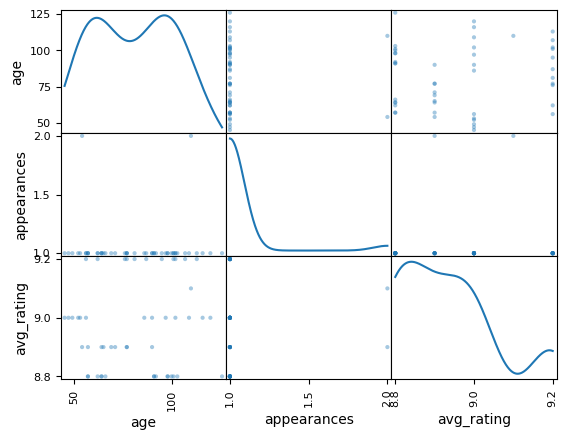

In [8]:
analyze.scattermatrix_actors(
    df_actor_features.drop(df_actor_features[df_actor_features["age"] == -1].index)
)

# outlook

- scrape random movies and try to classify if a given actor could really make it using the top 250 (interesting outliers for certain actors included in top 250 that say only did a single movie)
- try to predict imdb rating